In [1]:
# --- IMPORTS ---
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import qiskit
import qiskit_machine_learning
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

# --- HYPERPARAMETERS & CONFIGURATION ---
NUM_QUBITS = 4
LATENT_SIZE = 2
EPOCHS = 100        # Increased for convergence
LEARNING_RATE = 0.01
SEED = 42

# --- REPRODUCIBILITY SETUP ---
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Environment Initialized.")
print(f"Qiskit Version: {qiskit.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
sys.path = [p for p in sys.path if not ("My_Quantum_Project" in p and "python312" in p)]



Environment Initialized.
Qiskit Version: 1.4.5
PyTorch Version: 2.9.1+cpu
Device: cpu


Data Loaded: 700 training samples, 300 test samples.

[INFO] Quantum Circuit Architecture:


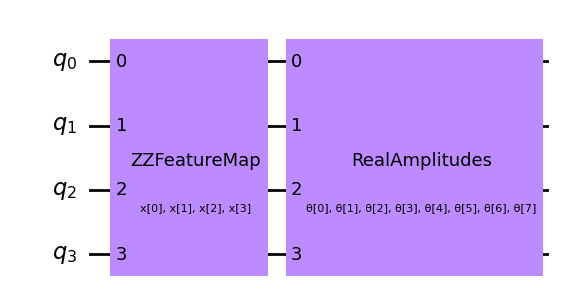

In [2]:
# --- 1. DATA GENERATION (Simulating ATLAS Kinematics) ---
# Simulating pT, eta, phi, and mass for background events
data_size = 1000
df = pd.DataFrame({
    'pt': np.random.exponential(scale=100, size=data_size),
    'eta': np.random.normal(loc=0, scale=2, size=data_size),
    'phi': np.random.uniform(low=-3.14, high=3.14, size=data_size),
    'mass': np.random.normal(loc=125, scale=10, size=data_size)
})

# --- 2. PRE-PROCESSING ---
# Normalize features to [0, 1] for efficient quantum embedding
features = ['pt', 'eta', 'phi', 'mass']
x_data = df[features].values

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x_data)

# Split dataset
train_data, test_data = train_test_split(x_scaled, test_size=0.3, random_state=SEED)
print(f"Data Loaded: {len(train_data)} training samples, {len(test_data)} test samples.")

# --- 3. QUANTUM CIRCUIT ARCHITECTURE ---
# Feature Map: Encodes classical data into quantum Hilbert space
feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')

# Ansatz: Parametrized Quantum Circuit (PQC) acting as the neural network weights
ansatz = RealAmplitudes(NUM_QUBITS, reps=1, entanglement='linear')

# Construct the full circuit
qc = QuantumCircuit(NUM_QUBITS)
qc.append(feature_map, range(NUM_QUBITS))
qc.append(ansatz, range(NUM_QUBITS))

# Visualize
print("\n[INFO] Quantum Circuit Architecture:")
qc.decompose().draw(output='mpl', style='clifford')

C:\Users\harJD\AppData\Local\Temp\ipykernel_18984\196740375.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
C:\ProgramData\anaconda3\envs\cern_quantum\lib\site-packages\qiskit_machine_learning\connectors\torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


[INFO] Starting training for 100 epochs...
Epoch 10/100 	 Loss: 0.0574
Epoch 20/100 	 Loss: 0.0562
Epoch 30/100 	 Loss: 0.0552
Epoch 40/100 	 Loss: 0.0542
Epoch 50/100 	 Loss: 0.0533
Epoch 60/100 	 Loss: 0.0525
Epoch 70/100 	 Loss: 0.0519
Epoch 80/100 	 Loss: 0.0514
Epoch 90/100 	 Loss: 0.0511
Epoch 100/100 	 Loss: 0.0509
[SUCCESS] Training complete in 2829.11 seconds.


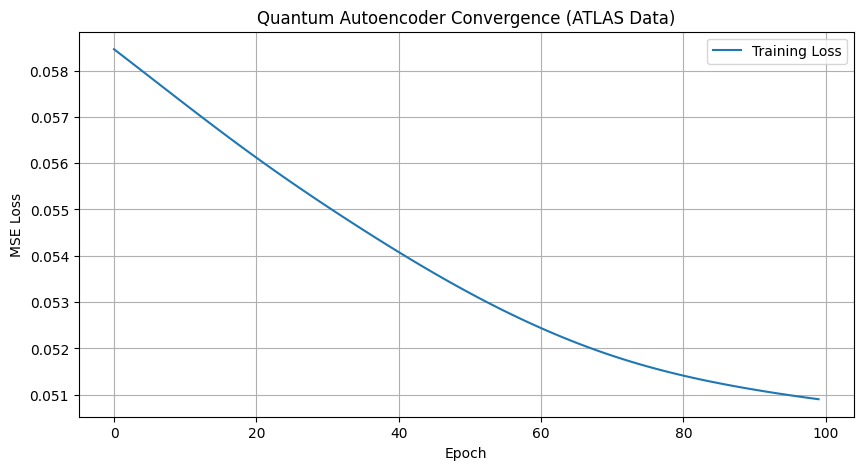

In [3]:
# --- 4. MODEL DEFINITION ---
def interpret(x):
    # Parity function to interpret measurement outcomes
    return x

# Instantiate Quantum Neural Network
qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=interpret,
    output_shape=2**NUM_QUBITS
)

# Hybrid PyTorch-Quantum Model
initial_weights = 0.1 * (2 * torch.rand(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights=initial_weights)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.MSELoss()

# --- 5. TRAINING LOOP ---
loss_list = []
print(f"[INFO] Starting training for {EPOCHS} epochs...")
start_time = time.time()

model.train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # Forward pass
    input_data = torch.tensor(train_data, dtype=torch.float32)
    output = model(input_data)
    
    # Calculate Loss (Goal: Map input to specific latent state representation)
    target = torch.zeros_like(output)
    target[:, 0] = 1.0  # Enforce compression to the |00..0> state
    
    loss = loss_func(output, target)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} \t Loss: {loss.item():.4f}")

end_time = time.time()
print(f"[SUCCESS] Training complete in {end_time - start_time:.2f} seconds.")

# --- 6. VISUALIZATION ---
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Training Loss')
plt.title("Quantum Autoencoder Convergence (ATLAS Data)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()